# Imports

In [147]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio

# Visulaizing Data

Image has shape: (160, 320, 3)


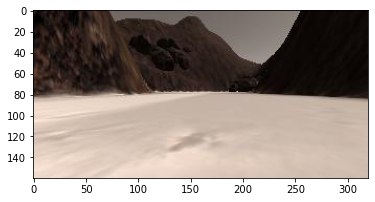

In [148]:
path = './IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)
print(f"Image has shape: {image.shape}")

# Calibration

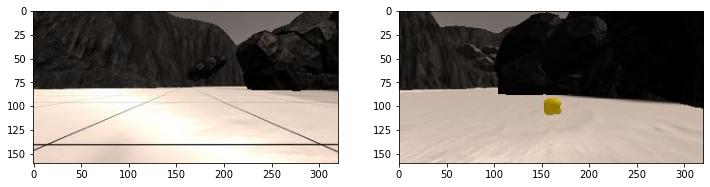

In [149]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = './calibration_images/example_grid1.jpg'
example_rock = './calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

# Perspective Transform

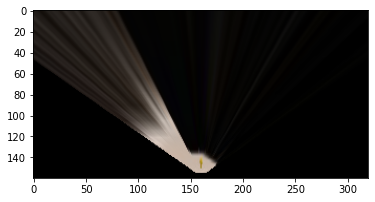

In [150]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst, kernel_size=3):
    img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5
bottom_offset = 6
source = np.float32([[19,140],
                     [303,140],
                     [200,95],
                     [120,95]
                    ])
destination = np.float32([[image.shape[1]/2 - dst_size,image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size,image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size,image.shape[0] - dst_size*2 - bottom_offset],
                          [image.shape[1]/2 - dst_size,image.shape[0] - dst_size*2 - bottom_offset]
])
warped = perspect_transform(rock_img, source, destination,kernel_size=3)
plt.imshow(warped)

# Color Thresholding

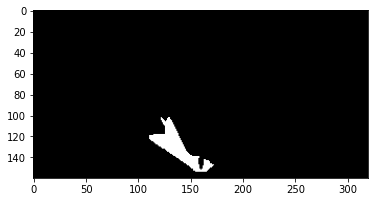

In [185]:
def color_thresh(img, rgb_thresh=(160, 160, 160),kernel_size=3):
    # Create an array of zeros same xy size as img, but single channel
    img = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed,cmap="gray")

In [142]:
x = np.zeros_like(warped[:,:,:])
x[:,:,0] = 1

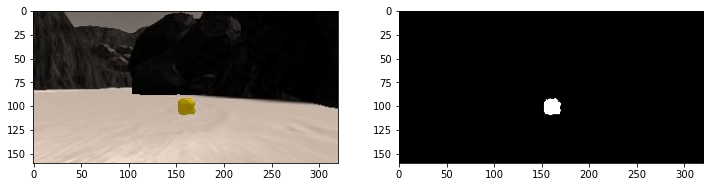

In [177]:
def find_rocks(img,Rock_thresh=(100,100,60)):
    rockpix=((img[:,:,0]>Rock_thresh[0])\
            & (img[:,:,1]>Rock_thresh[1])\
            &(img[:,:,2]<Rock_thresh[2]))
    color_select=np.zeros_like(img[:,:,0])
    color_select[rockpix]=1

    return color_select
rock_map=find_rocks(rock_img)

fig=plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map,cmap='gray')

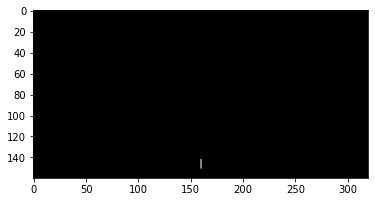

In [188]:
obs_threshed = 1 - color_thresh(warped, (85,85,85))
path_threshed = color_thresh(warped) # find only the navigatable path
rock_threshed = find_rocks(warped) # find rock samples
warped = perspect_transform(rock_img, source, destination,kernel_size=3)
plt.imshow(rock_threshed,cmap="gray")

# Coordinate Transformations

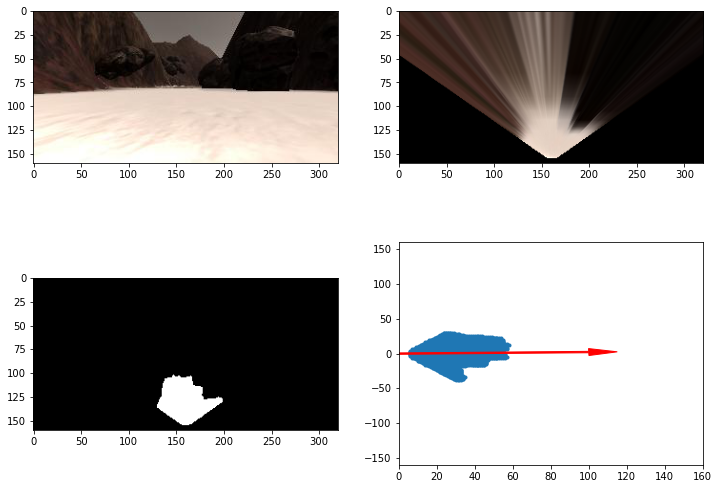

In [191]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [ ]:
fig = plt.figure(figsize=(12,9))


In [76]:
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('./robot_log.csv', delimiter=';', decimal='.')
print(df.head())

                                                Path  SteerAngle  Throttle  \
0  /home/seif_mostafa/vision/vision_project/IMG/r...         0.0       0.0   
1  /home/seif_mostafa/vision/vision_project/IMG/r...         0.0       0.0   
2  /home/seif_mostafa/vision/vision_project/IMG/r...         0.0       0.0   
3  /home/seif_mostafa/vision/vision_project/IMG/r...         0.0       0.0   
4  /home/seif_mostafa/vision/vision_project/IMG/r...         0.0       0.0   

   Brake  Speed  X_Position  Y_Position     Pitch       Yaw          Roll  
0    1.0    0.0    99.66999    85.58897  0.000236  56.82556 -4.130841e-07  
1    0.0    0.0    99.66999    85.58897  0.000236  56.82556 -5.665031e-07  
2    0.0    0.0    99.66999    85.58897  0.000236  56.82556 -4.130841e-07  
3    0.0    0.0    99.66999    85.58897  0.000236  56.82556 -5.153635e-07  
4    0.0    0.0    99.66999    85.58897  0.000236  56.82556 -3.619445e-07  


In [84]:
csv_img_list = df["Path"].tolist() # Create list of image pathnames
print(csv_img_list[:1])

['/home/seif_mostafa/vision/vision_project/IMG/robocam_2022_12_05_16_22_16_277.jpg']


In [157]:
ground_truth = mpimg.imread('./calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


World map has a shape of (200, 200)


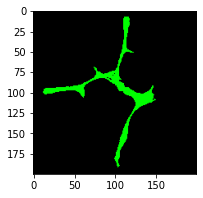

In [158]:
fig = plt.figure(figsize=(4,3))
plt.imshow(ground_truth,cmap="gray")
print(f"World map has a shape of {ground_truth.shape}")
plt.imshow(ground_truth_3d)

In [97]:
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float32)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [98]:
print(data)